In [1]:
import numpy as np
import torch
import h5py
import torch.nn as nn
import torch_geometric
import torch.nn.functional as F
import torch_geometric.nn as PyG
from torch_geometric.transforms import Distance
from torch_geometric.data import DataLoader
from torch_geometric.data import Data as PyGData
from torch_geometric.data import Data
import sys, os
import subprocess
import csv, yaml
import math
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.optim as optim
import argparse
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append("./python")
from model.allModel import *

In [3]:
# args = parser.parse_args() ## not jupyter
import easydict
args = easydict.EasyDict({
    "config" : 'config_lhe_wbjet_test.yaml' ,
    "output" : '2021222_test',
    "epoch" : 10,
    "seed" : 12345,
    "lr" : 1e-4,
    "batch" : 1000000,
    "model" : 'GNN3layer',
    "fea" : 4,
    "cla" : 1,
    "device" : 3

   
})

In [4]:
config = yaml.load(open(args.config).read(), Loader=yaml.FullLoader)
config['training']['learningRate'] = float(config['training']['learningRate'])
if args.seed: config['training']['randomSeed1'] = args.seed
if args.epoch: config['training']['epoch'] = args.epoch
if args.lr: config['training']['learningRate'] = args.lr

In [5]:
torch.set_num_threads(os.cpu_count())
if torch.cuda.is_available() and args.device >= 0: torch.cuda.set_device(args.device)
if not os.path.exists('result/' + args.output): os.makedirs('result/' + args.output)

In [6]:
import time
start = time.time()
##### Define dataset instance #####
from dataset.HEPGNNDataset_h5_LHE_re2 import *
dset = HEPGNNDataset_h5_LHE_re2()
for sampleInfo in config['samples']:
    if 'ignore' in sampleInfo and sampleInfo['ignore']: continue
    name = sampleInfo['name']
    dset.addSample(name, sampleInfo['path'], weight=sampleInfo['xsec']/sampleInfo['ngen'])
    dset.setProcessLabel(name, sampleInfo['label'])
dset.initialize()

4top /store/hep/users/jhgoh/nurion4hep/20211211_1/graph/8285877F-4B82-6B4B-BDD2-CDBABE12443D.h5
  procName                                           fileName        weight  \
0     4top  /store/hep/users/jhgoh/nurion4hep/20211211_1/g...  1.004000e-09   

  fileIdx  nEvent  label  
0       0     0.0    1.0  

--------------------------------------------------------------------------------


In [7]:
lengths = [int(x*len(dset)) for x in config['training']['splitFractions']]
lengths.append(len(dset)-sum(lengths))
# torch.manual_seed(config['training']['randomSeed1'])
kwargs = {'num_workers':min(config['training']['nDataLoaders'], os.cpu_count()),
          'batch_size':args.batch, 'pin_memory':False}

In [8]:
testLoader = DataLoader(dset, **kwargs)
# torch.manual_seed(torch.initial_seed())

In [9]:
from model.allModel import *

model = torch.load('result/' + args.output+'/model.pth', map_location='cpu')
model.load_state_dict(torch.load('result/' + args.output+'/weight.pth', map_location='cpu'))


device = 'cpu'
if args.device >= 0 and torch.cuda.is_available():
    model = model.cuda()
    device = 'cuda'

In [10]:
model

GCN3(
  (conv1): GCNConv(4, 32)
  (conv2): GCNConv(32, 64)
  (conv3): GCNConv(64, 64)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Softplus(beta=1, threshold=20)
  )
)

In [11]:
device = 'cuda:3'

#### Start evaluation #####
from tqdm import tqdm

datas = []
preds= []
batchs = []
for i, data in enumerate(tqdm(testLoader)):
    
    data = data.to(device)

    datas.append(data)
    
    pred = model(data)
    preds.append(pred)

100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


In [12]:
f = h5py.File('/store/hep/users/jhgoh/nurion4hep/20211211_1/graph/8285877F-4B82-6B4B-BDD2-CDBABE12443D.h5','r')

In [13]:
final_state = []
for i in range(len(f['events']['id'])):
    final_state.append((f['events']['status'][i] == 1).sum())

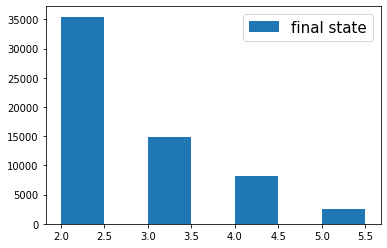

In [62]:
##### 전체 final state 갯수
plt.hist(final_state,label='final state',bins=np.arange(2,6,0.5))
plt.legend(loc='upper right',fontsize = 15)
plt.show()

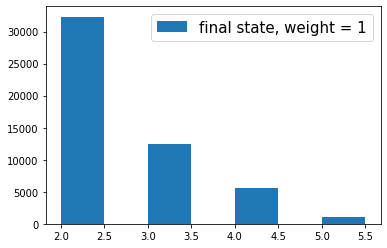

In [63]:
##### weight 1에 대한 final state 분포
plt.hist(np.array(final_state)[np.array(f['events']['weight']) == 1],label='final state, weight = 1',bins=np.arange(2,6,0.5))
plt.legend(loc='upper right',fontsize = 15)
plt.show()

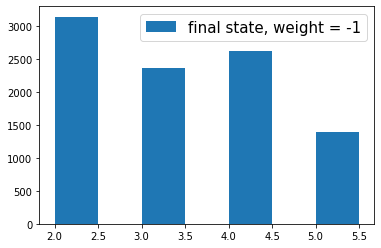

In [64]:
##### weight -1에 대한 final state 분포
plt.hist(np.array(final_state)[np.array(f['events']['weight']) == -1],label='final state, weight = -1',bins=np.arange(2,6,0.5))
plt.legend(loc='upper right',fontsize = 15)
plt.show()

In [17]:
ne_2 = (np.array(final_state)[np.array(f['events']['weight']) == -1] == 2).sum()
ne_3 = (np.array(final_state)[np.array(f['events']['weight']) == -1] == 3).sum()
ne_4 = (np.array(final_state)[np.array(f['events']['weight']) == -1] == 4).sum()
ne_5 = (np.array(final_state)[np.array(f['events']['weight']) == -1] == 5).sum()

In [18]:
po_2 = (np.array(final_state)[np.array(f['events']['weight']) == 1] == 2).sum()
po_3 = (np.array(final_state)[np.array(f['events']['weight']) == 1] == 3).sum()
po_4 = (np.array(final_state)[np.array(f['events']['weight']) == 1] == 4).sum()
po_5 = (np.array(final_state)[np.array(f['events']['weight']) == 1] == 5).sum()

In [19]:
def weight_guess(a, b):
    c = (a-b)/(a+b)
    return c

In [20]:
print(weight_guess(po_2,ne_2))
print(weight_guess(po_3,ne_3))
print(weight_guess(po_4,ne_4))
print(weight_guess(po_5,ne_5))

0.8228226534296029
0.6799296251184193
0.3557987947361948
-0.13599348534201955


In [72]:
print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 2]))
print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 3]))
print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 4]))
print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 5]))

0.8144424
0.6730444
0.31553042
0.19706398


In [73]:
print(np.mean(np.array(preds[0].to('cpu').detach().numpy())))
# print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 3]))
# print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 4]))
# print(np.mean(np.array(preds[0].to('cpu').detach().numpy())[np.array(final_state) == 5]))

0.68845767


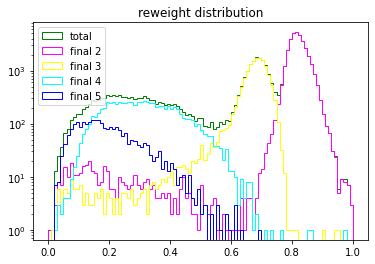

In [37]:
plt.hist(preds[0].to('cpu').detach().numpy(), histtype='step', linewidth=1,
             density=False, bins=100, color='green',label='total',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 2], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,0,1],label='final 2',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 3], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,1,0],label='final 3',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 4], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,1,1],label='final 4',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 5], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,0,1],label='final 5',range=(0,1)) 
plt.yscale('log')
plt.legend(loc='upper left',fontsize= 10)
plt.title('reweight distribution')
plt.show()

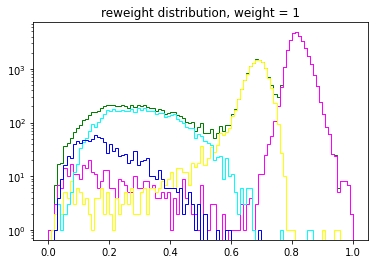

In [38]:
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == 1], histtype='step', linewidth=1,
             density=False, bins=100, color='green',label='total',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == 1][np.array(final_state)[np.array(f['events']['weight']) == 1] == 2], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,0,1],label='final 2',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == 1][np.array(final_state)[np.array(f['events']['weight']) == 1] == 3], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,1,0],label='final 3',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == 1][np.array(final_state)[np.array(f['events']['weight']) == 1] == 4], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,1,1],label='final 4',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == 1][np.array(final_state)[np.array(f['events']['weight']) == 1] == 5], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,0,1],label='final 5',range=(0,1)) 
plt.title('reweight distribution, weight = 1')
plt.yscale('log')
# plt.legend(loc='upper left')
plt.show()

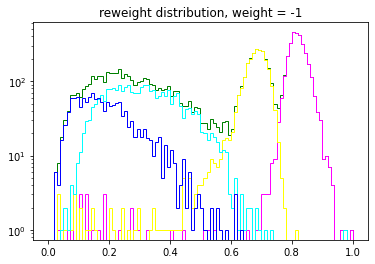

In [39]:
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == -1], histtype='step', linewidth=1,
             density=False, bins=100, color='green',label='total',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == -1][np.array(final_state)[np.array(f['events']['weight']) == -1] == 2], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,0,1],label='final 2',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == -1][np.array(final_state)[np.array(f['events']['weight']) == -1] == 3], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,1,0],label='final 3',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == -1][np.array(final_state)[np.array(f['events']['weight']) == -1] == 4], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,1,1],label='final 4',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(f['events']['weight']) == -1][np.array(final_state)[np.array(f['events']['weight']) == -1] == 5], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,0,1],label='final 5',range=(0,1)) 
plt.title('reweight distribution, weight = -1')
# plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

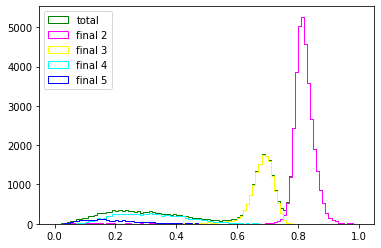

In [26]:
plt.hist(preds[0].to('cpu').detach().numpy(), histtype='step', linewidth=1,
             density=False, bins=100, color='green',label='total',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 2], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,0,1],label='final 2',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 3], histtype='step', linewidth=1,
             density=False, bins=100, color=[1,1,0],label='final 3',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 4], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,1,1],label='final 4',range=(0,1)) 
plt.hist(preds[0].to('cpu').detach().numpy()[np.array(final_state) == 5], histtype='step', linewidth=1,
             density=False, bins=100, color=[0,0,1],label='final 5',range=(0,1)) 
plt.legend(loc='upper left')
plt.show()